# Tutorial Modelos de Ensamble tipo XGBoost

En este tutorial aplicaremos un modelo de ensamble tipo XGBoost a una serie de precios. Este tutorial se enfoca a generar una estructura en los datos que permita un pronóstico hacia adelante. Es decir, buscamos generar una estructura de ensamble a un conjunto de datos condicionados a eventos pasados, para luego generar un pronóstico futuro de los mismos. La serie por tanto genera una estructura de ensamble entrenada en una sección correspondiente de entrenamiento para luego generar un pronóstico hacia adelante en una estructura de datos transformada y mediante un modelo con refinamiento de parámetros.

**Contenido**
1. [Importación de librerías requeridas](#2)
1. [Importación de datos financieros](#3)
1. [Preprocesamiento de datos](#5)
1. [Partición de datos en entrenamiento y prueba](#6)
1. [Visualización conjunto de entrenamiento y prueba](#7)
1. [Regresión con Random Forest](#7a)
1. [Creación del Forecaster](#8)
1. [Predicciones en conjuto de prueba](#9)
1. [Refinamiento de los hiperparámetros](#10)
1. [Aplicación modelo óptimo a serie completa](#11)
1. [Generación del pronóstico hacia adelante](#12)
1. [Visualización del pronóstico futuro](#13)

<a id="2"></a> <br>
### 1. Importación de librerías requeridas

Importa las siguientes librerías para desarrollar este tutorial:

In [1]:
!pip install ipykernel
!pip install skforecast
!pip install skforecast[full]
#!pip install skforecast==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 64.5 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.1
    Uninstalling pandas-2.2.1:
      Successfully uninstalled pandas-2.2.1
  Attempting uninstall: optuna
    Found existing installation: optuna 3.6.1
    Uninstalling optuna-3.6.1:
      Successfully uninstalled optuna-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.5 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is i

In [2]:
#Esta es requerida para importar los datos financieros
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=293152 sha256=f73a2eb12e40dec793dcc148f4d82dd5e5671773db3aa0c4b82c56151c37f06c
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee


In [1]:
# Manipulación datos
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#XGBoost:
# Modelado y Forecasting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
warnings.filterwarnings('once')

In [2]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
#yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

/Users/U1037319/Downloads/tmenv/lib/python3.10/site-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [7]:
##Si tienes problemas para descargar pandas datareader, puedes probar la siguiente línea:
!pip install git+https://github.com/pydata/pandas-datareader.git

  Cloning https://github.com/pydata/pandas-datareader.git to /tmp/pip-req-build-9ftvlbq5
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/pandas-datareader.git /tmp/pip-req-build-9ftvlbq5
  Resolved https://github.com/pydata/pandas-datareader.git to commit a1cf7a20fe03dd63e930fa5ca1311a57897c9ddd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandas-datareader: filename=pandas_datareader-0.11.0.dev55+ga1cf7a2-py3-none-any.whl size=114240 sha256=acb81f3253a6e19a917717077ec9f491b73f9ab9efc7706f47534ccc684d5013
  Stored in directory: /tmp/pip-ephem-wheel-cache-seulqd9x/wheels/8e/ee/f8/83ddbd27100f359877dac9de223dd44e42750c8ec60b3fe253
Successfully built pandas-datareader
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.10.0
    Uninstalling pandas-datareader-0.10.0:
      Successfully uninstalled pandas-da

<a id="3"></a> <br>
### 2. Importación de datos financieros

Establecemos primeramente la fecha de inicio y fin, así como el activo o los activos de interés. En este ejemplo, emplearemos únicamente un activo, pero dejo desactivados otros ejemplos de stocks (stks), índices (idx), monedas (ccy) como ejemplos de otros activos.

In [3]:
#Establecemos las fechas de consulta:
start = '2015-01-01'
end = '2022-07-29'
#ticker = 'AAPL'
#data = pdr.get_data_yahoo(ticker, start, end)['Adj Close']
#gs10='GS10'
#stks_tickers = ['AAPL','IBM', 'GOOGL']
#idx_tickers = ['SPY', '^DJI', '^VIX']
#ccy_tickers = ['JPY=X', 'GBPUSD=X']

In [4]:
#Una vez declarado el ticker, pedimos a través de la función de pandas data reader (pdr), bajar lso datos de la fuente de yahoo finance.
#data = pdr.get_data_yahoo("AMZN", start, end)['Close']
import yfinance as yf

data = yf.download("AAPL", start="2015-01-01", end="2022-07-29")['Close']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [15]:
#Pasamos a data frame los datos, cambiamos el nombre de la columna del tipo de precio a "y", para facilidad posterior.
dt= pandas.DataFrame(data)
df= dt.rename(columns={'AAPL': 'y'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1906 entries, 2015-01-02 to 2022-07-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1906 non-null   float64
dtypes: float64(1)
memory usage: 29.8 KB


In [16]:
df.head()

Ticker,y
Date,
2015-01-02,24.320436
2015-01-05,23.635283
2015-01-06,23.637512
2015-01-07,23.968960
2015-01-08,24.889902


<a id="5"></a> <br>
### 3. Preprocesamiento de datos

En esta parte, debemos dar especial formato a la columna de fechas, así como a su frecuencia. Esto es importante para que el pronóstico mediante la función de regresión funcione apropiadamente. 

In [17]:
# Preparación formato datos
# ==============================================================================
dataindex= pd.to_datetime(df.index)
dataindex

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28'],
              dtype='datetime64[ns]', name='Date', length=1906, freq=None)

In [18]:
# Damos formato de fecha con periodiciadad diaria a la serie.
df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d')  
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  
df = df.set_index('Date')
df = df.asfreq('B')  #Frecuencia diaria-negocios
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1975 entries, 2015-01-02 to 2022-07-28
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1906 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB


In [19]:
## Imputamos algún valor faltante con el valor anterior.
df.fillna(method='bfill', inplace=True)

In [20]:
# Podemos verificar si valores faltantes.
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


<a id="6"></a> <br>
### 4. Partición de datos en entrenamiento y prueba

En esta seción, partimos el conjunto de datos de pueba y de entrenamiento. 

In [21]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = df[:-steps]
data_test  = df[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

Train dates : 2015-01-02 00:00:00 --- 2022-06-08 00:00:00  (n=1939)
Test dates  : 2022-06-09 00:00:00 --- 2022-07-28 00:00:00  (n=36)


In [22]:
data_train.head()

Ticker,y
Date,
2015-01-02,24.320436
2015-01-05,23.635283
2015-01-06,23.637512
2015-01-07,23.968960
2015-01-08,24.889902


In [23]:
#Identificamos la longitud de la serie
len(df)

1975

In [24]:
data_train.head()

Ticker,y
Date,
2015-01-02,24.320436
2015-01-05,23.635283
2015-01-06,23.637512
2015-01-07,23.968960
2015-01-08,24.889902


<a id="4"></a> <br>
### 5. Visualización de datos financieros

Para mirar la serie, debemos importar la librería de matplotlib.

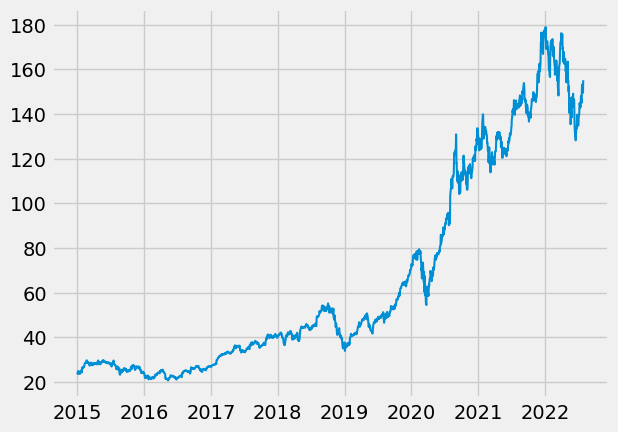

In [25]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(df)

In [26]:
#Vemos los datos para las fechas que nos sirven para las gráficas
date_train
#date_test  #Igualmente para visualizarlos

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
               '2022-05-27', '2022-05-31', '2022-06-01', '2022-06-02',
               '2022-06-03', '2022-06-06'],
              dtype='datetime64[ns]', name='Date', length=1870, freq=None)

<a id="7"></a> <br>
### 6. Visualización conjunto de entrenamiento y prueba

In [27]:
#Imprimimos la longitud de ambos conjuntos de datos:
print(len(data_train))
print(len(data_test))

1939
36


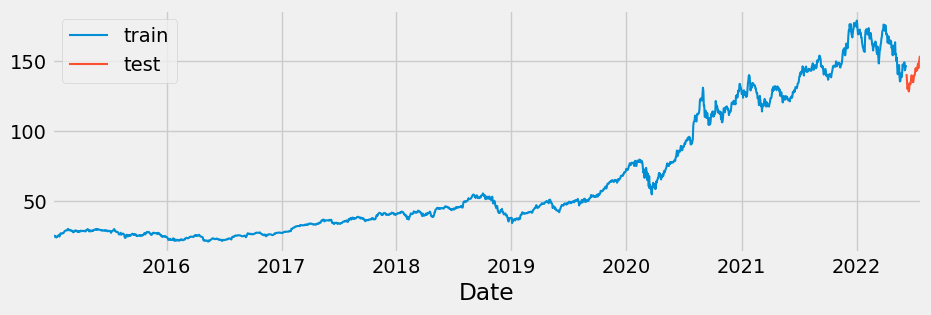

In [28]:
fig, ax = plt.subplots(figsize=(10, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

Ahora verificamos como quedo la partición de nuestra serie de tiempo:

In [29]:
#Otra opción, es emplear la librería de go.Scatter para otro tipo de gráfico. 
trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'test'
)

layout = go.Layout(
    title = "AMZN ",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Price"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

<a id="7a"></a> <br>
# 6. Regresión con XGBoost
En esta sección, comenzaremos la regresión empleando el algoritmo de Random Forest. Para ello, comenzaremos con la creación de la estructura de datos tipo aprendizaje supervisado. Esto se hace mediante la función de ForecasterAutoreg.

<a id="8"></a> <br>
### 7. Creación del Forecaster con XGBoost

En esta sección aplicamos la función de Forecast Aurtoregress para la creación de ventanas con ciertos retrazos al cual se aplica el modelo de Random Forest. En este caso, consideramos 10 retrazos que capturan la estructura de datos de la serie y generan un pronóstico a 10 días. Esto significa que el modelo emplea los 10 días previos como predictores. Así, por ejemplo, si se tuviera una sección de prueba de 6 días, con un tamaño de ventana de 3 rezagos, la dimensión del conjunto de datos de prueba cuando se entrenara el modelo sería de (6x3):
* "Train"  "Pron"
* [1,2,3]   [4]
* [2,3,4]   [5]
* [3,4,5]   [6]
* [4,5,6]   [7]
* [5,6,7]   [8]
* [6,7,8]   [9]


In [30]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, en este caso, creando ventanas de 10 días:
# ==============================================================================
forecaster_xgb = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 10
                )

forecaster_xgb.fit(y=data_train['y'])
forecaster_xgb

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variabl

<a id="9"></a> <br>
### 8. Predicciones en conjunto de prueba


Verifiquemos el rendimiento del modelo entrenado en el conjunto de test o prueba.

In [31]:
# Pronóstico, en este caso elegimos una ventana de n-test días.
# ==============================================================================
steps = 36  ## el mismo que la ventana de test
predictions_xgb = forecaster_xgb.predict(steps=steps)
predictions_xgb.head(5)

2022-06-09    144.283691
2022-06-10    142.964172
2022-06-13    144.257278
2022-06-14    144.220078
2022-06-15    142.701233
Freq: B, Name: pred, dtype: float64

In [32]:
#Hasta aquí, es improtante verificar que el pronóstico esté indexado por la fecha, en la frecuencia adecuada. Con ello, el refinamiento de los parámetros es posible.

In [33]:
# Determinamos el error de pronóstico:
# ==============================================================================
error_mse_xgb = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions_xgb
            )

print(f"Test error (mse): {error_mse_xgb}")
RMSE = sqrt(error_mse_xgb)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 61.18197197826683
Test error (rmse): 7.821890562918075


<a id="10"></a> <br>
### 9. Refinamiento de los hiperparámetros

La función que entrena los datos emplea la configuración sugerida por el usuario donde el modelo de Random Forest aplica la configuración por default de los hiperparámetros. Sin embargo, no existe sustento que esta configuración sea la ideal. Por tanto y para encontrar la mejor combinación de retrazos e hiperparámetros, podemos emplear la librería de Skforecast la cual provee la función de búsqueda con los parámetros que minimicen la métrica de error. Con esta configuración, podemos posteriormente ajustar el modelo para el pronóstico.

In [34]:
# Cálculo de hiperparámetros por grid search
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


resultados_grid_xgb = grid_search_forecaster(
        forecaster         = forecaster_xgb,
        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 48.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 75.99120681515367



In [35]:
# Visualizamos los resultados del grid search
# ==============================================================================
resultados_grid_xgb.head(10)

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
37,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",75.991207,0.01,3.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",89.619707,0.10,3.0,100.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",90.630526,0.10,5.0,500.0
42,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",91.787323,0.10,3.0,100.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",92.754091,0.01,5.0,500.0
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",94.862221,0.01,3.0,500.0
47,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",96.930803,0.10,10.0,500.0
39,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",97.169297,0.01,5.0,500.0
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",97.264986,0.10,3.0,100.0
46,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",97.454374,0.10,10.0,100.0


<a id="11"></a> <br>
### 10. Aplicación modelo óptimo a serie completa

A partir de la salida anterior, ¿cuáles deberían las variables a escoger para entrenar el modelo?

In [36]:
# Creamos y entrenamos el modelo de XGB con la función de estructura de datos generada a través de la función Forecaster, y condiciones del refinamiento, creando ventanas de 10 días:
#forecaster_xgb = ForecasterAutoreg(
#                regressor = XGBRegressor(learning_rate=0.10, n_estimators=100, random_state=123),
#                lags = 10
#                )

#forecaster_xgb.fit(y=df['y'])
#forecaster_xgb


#AJUSTANDO SEGUN EJERCICIO

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from xgboost import XGBRegressor

# Lista de lags personalizados que querés usar como predictores
custom_lags = [1, 2, 3, 23, 24, 25, 71, 72, 73]

# Crear el forecaster con lags personalizados
forecaster_xgb = ForecasterAutoreg(
    regressor = XGBRegressor(learning_rate=0.10, n_estimators=100, random_state=123),
    lags = custom_lags
)

# Entrenar el modelo con la serie temporal
forecaster_xgb.fit(y=df['y'])


In [37]:
# Podemos imprimir la importancia de los rezagos
forecaster_xgb.get_feature_importances()

,feature,importance
0,lag_1,0.120146
1,lag_2,0.556337
2,lag_3,0.288658
3,lag_23,0.032980
4,lag_24,0.001244
5,lag_25,0.000135
6,lag_71,0.000192
7,lag_72,0.000172
8,lag_73,0.000136


Como podemos ver, los primeros tres rezagos son los que más aportan al modelo.

<a id="12"></a> <br>
### 11. Generación del pronóstico hacia adelante

Una vez que el modelo es entrenado, se genera el pronóstico futuro.

In [38]:
# Pronóstico, en este caso elegimos una ventana de 12 días.
# Pronóstico, en este caso elegimos una ventana de 10 días.
# ==============================================================================
steps = 10
predictions_xgb_fwd= forecaster_xgb.predict(steps=steps)
predictions_xgb_fwd.head(5)

2022-07-29    155.983170
2022-08-01    156.112854
2022-08-02    156.517029
2022-08-03    157.457794
2022-08-04    159.002991
Freq: B, Name: pred, dtype: float64

In [40]:
## Generamos las fechas a dichos pronósticos mediante la función de pandas date_range:
fin = data_test.index.max()   #Partimos de la fecha máxima de la sección de prueba, hacia adelante.
fwd_dates = pd.date_range(fin, periods=12, freq='D').tolist()
fwd_dates

[Timestamp('2022-07-28 00:00:00'),
 Timestamp('2022-07-29 00:00:00'),
 Timestamp('2022-07-30 00:00:00'),
 Timestamp('2022-07-31 00:00:00'),
 Timestamp('2022-08-01 00:00:00'),
 Timestamp('2022-08-02 00:00:00'),
 Timestamp('2022-08-03 00:00:00'),
 Timestamp('2022-08-04 00:00:00'),
 Timestamp('2022-08-05 00:00:00'),
 Timestamp('2022-08-06 00:00:00'),
 Timestamp('2022-08-07 00:00:00'),
 Timestamp('2022-08-08 00:00:00')]

<a id="13"></a> <br>
### 12. Visualización del pronóstico futuro

A continuación verás graficamente las tres series de tiempo (train, test y forecast). El gráfico es interactivo, amplia la zona donde están las series de test y forecast.

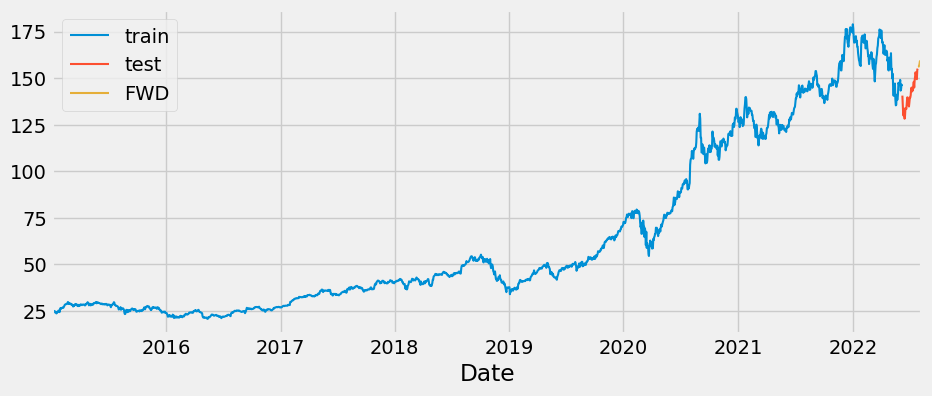

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions_xgb_fwd.loc[:].plot(ax=ax, label='FWD')
ax.legend();

In [42]:
#Tambien podemos usar este formato para graficar las partes de la serie, aunando el valor del pronóstico.

trace3 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'Test'
)

trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Train'
    )

trace5 = go.Scatter(
    x = fwd_dates,
    y = predictions_xgb_fwd,
    mode = 'lines',
    name = 'Pronóstico Futuro XGB'
    )
layout = go.Layout(
    title = "Amzn Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace5], layout=layout)
fig.show()

En este tutorial aprendiste un proceso para la generación de pronósticos futuros de una serie financiera mediante modelos de ensamble tipo Boosting. En el proceso, reiteramos la importancia de transformar los datos de una serie de tiempo en una estructura de datos que permiten generar secuencias de entrenamiento y pronóstico de la serie con base en datos históricos. Este proceso se debe hacer especialmente cuando deseamos generar un pronóstico hacia adelante en series de tiempo. Dicho proceso es muy similar al que se emplea cuando aplicamos un problema supervisado tal como una regresión lineal o modelos regresivos, donde se generan los retrasos o lags de la serie y cuyos features ingresan al modelo de regresión. En este caso, se crea una estructura en la cual se puede emplear para entrenar un modelo de ensamble cuyo proceso puede ser tedioso. Para ello, existen funciones que ayudan es esa tarea, en el caso particular de este tutorial, empleamos la función de Forecaster Autoregressor que crea la estructura de datos y aplica el modelo de y XGBoost con los parámetros suministrados. Una vez obtenido el modelo se genera el pronóstico futuro especificando la serie a emplear.

In [43]:
steps = 36  ## el mismo que la ventana de test
predictions_xgb = forecaster_xgb.predict(steps=steps)

# Determinamos el error de pronóstico:
# ==============================================================================
error_mse_xgb = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions_xgb
            )

print(f"Test error (mse): {error_mse_xgb}")
RMSE = sqrt(error_mse_xgb)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 392.12152849931346
Test error (rmse): 19.802058693461987


**Referencia:**

 Este tutorial emplea la función ForecasterAutoreg de la paquetería skforecast (https://pypi.org/project/skforecast/). 
 
 Ceballos, F. 2019. Stacking classifiers for higher predictive performance. Towards Data Science. Retrieved from: https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840 